In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import SilhouetteVisualizer
from tqdm.notebook import tqdm, tnrange
import timeit
from time import sleep

from sklearn import manifold
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

In [2]:
flierprop = {"marker": "o", "markersize": "5"}

meanprop = {
    "marker": "o",
    "markerfacecolor": "white",
    "markeredgecolor": "black",
    "markersize": "7"
}

boxprop = dict(boxstyle='round', facecolor='w',
               alpha=0.8)  # Param. pour annotations

timelapse = []

if not os.path.exists('P5_clustering'):
    os.makedirs('P5_clustering')

### Matrice de corrélation sur les variables finales
Récence et fréquence sont corrélées

<AxesSubplot:>

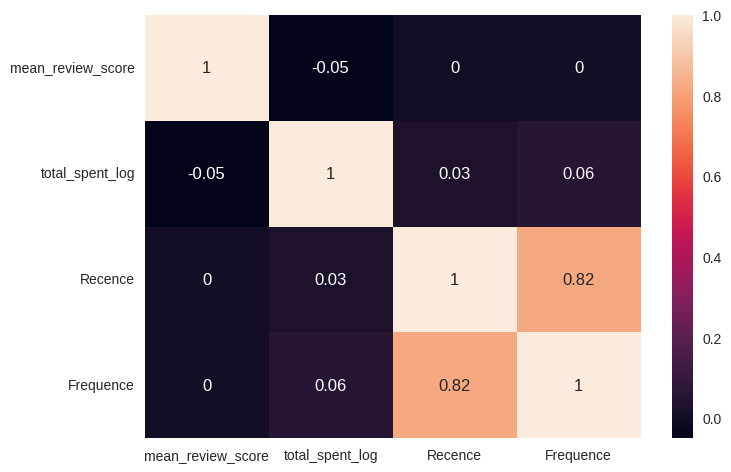

In [3]:
df_inputData = pd.read_csv(
    'input_clustering.csv',
    sep=",").set_index('customer_unique_id').drop(columns='total_spent')

sns.heatmap(np.round(df_inputData.corr(), 2), annot=True)

In [4]:
df_inputData.head()

,mean_review_score,total_spent_log,Recence,Frequence
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,5.0,7.148731,5,1
0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,4.765004,5,1
0000f46a3911fa3c0805444483337064,3.0,6.429951,0,0
0000f6ccb0745a6a4b88665a16c9f078,4.0,5.446918,2,1
0004aac84e0df4da2b147fca70cf8255,5.0,7.621246,0,0


# Test d'algorithmes

## DBScan

In [5]:
if not os.path.exists('P5_clustering/DBSCAN'):
    os.makedirs('P5_clustering/DBSCAN')

df_inputData = pd.read_csv('input_clustering.csv',
                           sep=",").set_index('customer_unique_id')
cols = df_inputData.drop(columns="total_spent").columns
X = MinMaxScaler().fit_transform(df_inputData[cols])
X = pd.DataFrame(X, columns=cols)
X

,mean_review_score,total_spent_log,Recence,Frequence
0,1.00,0.403871,1.0,0.25
1,0.75,0.156207,1.0,0.25
2,0.50,0.329191,0.0,0.00
3,0.75,0.227057,0.4,0.25
4,1.00,0.452964,0.0,0.00
...,...,...,...,...
92745,1.00,0.805423,1.0,0.25
92746,0.75,0.326313,0.0,0.00
92747,1.00,0.369017,0.0,0.00
92748,1.00,0.394937,0.6,0.25


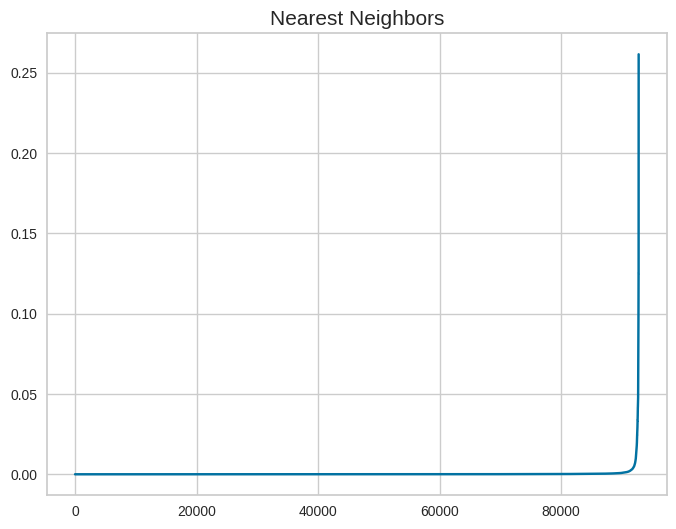

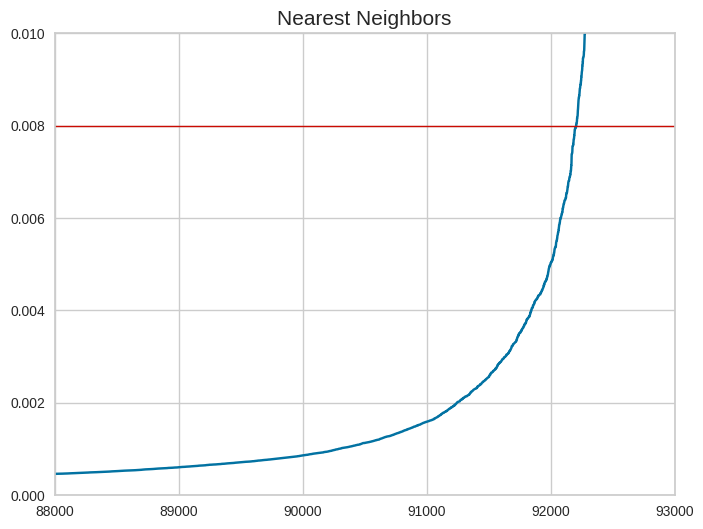

In [6]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(distances)
plt.title("Nearest Neighbors", fontsize=15)
plt.savefig("P5_clustering/DBSCAN/eps_NN.png", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(distances)
plt.xlim([88000, 93000])
plt.ylim([-0.0, 0.01])
plt.axhline(0.008, color='r', linewidth=1)
plt.title("Nearest Neighbors", fontsize=15)
plt.savefig("P5_clustering/DBSCAN/eps_NN_coude.png", bbox_inches='tight')

In [7]:
start_time = timeit.default_timer()
db_default = DBSCAN(eps=0.008, min_samples=350).fit(X)
elapsed = timeit.default_timer() - start_time
timelapse.append(['DBSCAN_nn', elapsed])
print("elapsed time for clustering :" + str(np.round(elapsed, 2)))
# min_samples (nombre minimum de points dans le cluster) = nbe de dimensions mini + 1 = 5
# 5 clusters mais masse outliers??

lb = db_default.labels_

df_inputData['labels'] = lb
df_inputData.groupby('labels').mean().iloc[1:]

elapsed time for clustering :2.51


,mean_review_score,total_spent,total_spent_log,Recence,Frequence
labels,,,,,
0,5.0,110.672464,6.593053,5.0,1.0
1,5.0,110.622131,6.623985,0.0,0.0
2,5.0,107.454056,6.651724,3.0,1.0
3,5.0,107.108604,6.650398,2.0,1.0
4,5.0,109.400676,6.611407,4.0,1.0
5,5.0,36.457877,5.187093,0.0,0.0


In [8]:
start_time = timeit.default_timer()
db_scan=DBSCAN(eps=0.2, min_samples=50)
db_default = db_scan.fit(X)
elapsed = timeit.default_timer() - start_time
timelapse.append(['DBScan_man', elapsed])
print("elapsed time for clustering :" + str(np.round(elapsed, 2)))

lb = db_default.labels_

print(np.unique(db_default.labels_))

for l in np.unique(lb):
    print(l, list(lb).count(l))

df_inputData['labels'] = lb
df_inputData.groupby('labels').mean().iloc[1:]

elapsed time for clustering :12.7
[-1  0  1  2  3  4  5  6]
-1 136
0 56560
1 18591
2 14109
3 1992
4 80
5 1141
6 141


,mean_review_score,total_spent,total_spent_log,Recence,Frequence
labels,,,,,
0,4.149502,163.612340,6.795862,4.153236,1.0
1,4.488722,155.105498,6.736507,0.000000,0.0
2,4.163359,161.514233,6.785990,2.000000,1.0
3,1.000000,199.783720,7.025012,0.000000,0.0
4,4.728125,495.284625,8.626844,5.000000,3.0
5,4.353428,332.392954,7.982970,4.687117,2.0
6,4.622931,301.264043,7.883606,3.000000,2.0


## Hierarchique

In [9]:
df_inputData = pd.read_csv('input_clustering.csv',
                    sep=",").set_index('customer_unique_id')
cols = df_inputData.drop(columns="total_spent").columns
X = MinMaxScaler().fit_transform(df_inputData[cols])
X = pd.DataFrame(X, columns=cols)
X

Xx = X.sample(frac=0.25)
Xx.shape

(23188, 4)

In [10]:
start_time = timeit.default_timer()
Agg = AgglomerativeClustering(n_clusters=4,
                                  compute_full_tree=False).fit(Xx)
elapsed = timeit.default_timer() - start_time
print("elapsed time for clustering :" + str(np.round(elapsed, 2)))
timelapse.append(['AHC Ward', elapsed])

Xx['labels'] = Agg.labels_
Xx.groupby('labels').mean()

elapsed time for clustering :16.25


,mean_review_score,total_spent_log,Recence,Frequence
labels,,,,
0,0.202476,0.378791,0.660489,0.222581
1,0.871121,0.360810,0.000000,0.000000
2,0.936947,0.362542,0.619243,0.250000
3,0.931099,0.380568,0.989372,0.270503


## k-means

In [11]:
if not os.path.exists('P5_clustering/kmeans'):
    os.makedirs('P5_clustering/kmeans')

df_inputData = pd.read_csv('input_clustering.csv',
                    sep=",").set_index('customer_unique_id')

cols = df_inputData.drop(columns="total_spent").columns
X = MinMaxScaler().fit_transform(df_inputData[cols])
X = pd.DataFrame(X, columns=cols)
X

,mean_review_score,total_spent_log,Recence,Frequence
0,1.00,0.403871,1.0,0.25
1,0.75,0.156207,1.0,0.25
2,0.50,0.329191,0.0,0.00
3,0.75,0.227057,0.4,0.25
4,1.00,0.452964,0.0,0.00
...,...,...,...,...
92745,1.00,0.805423,1.0,0.25
92746,0.75,0.326313,0.0,0.00
92747,1.00,0.369017,0.0,0.00
92748,1.00,0.394937,0.6,0.25


In [24]:
inertia = []
silhouettes=[]

for i in tqdm(range(2, 10)):
    kMeanMod = KMeans(n_clusters=i)
    kMeanMod.fit(X)
    inertia.append(kMeanMod.inertia_)

  0%|          | 0/8 [00:00<?, ?it/s]

2
3
4
5
6
7
8
9


/tmp/ipykernel_351345/2439818823.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(1,10))


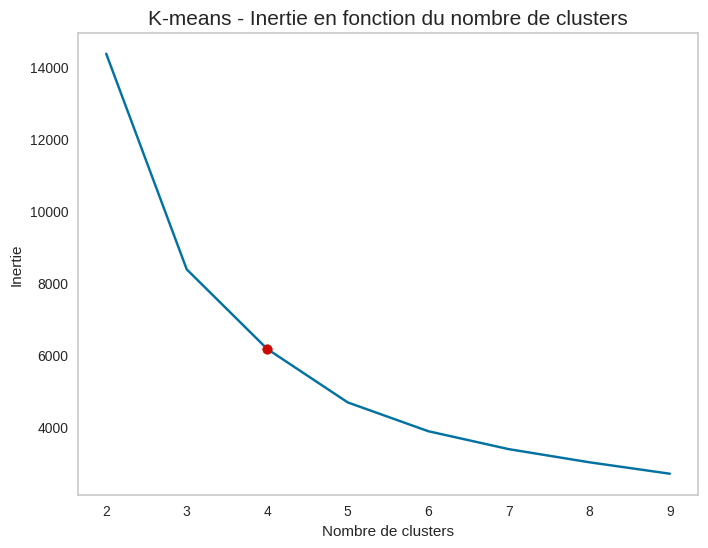

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(False)
plt.plot(inertia, zorder=0)
plt.scatter(2, inertia[2], color='r', zorder=1)
ax.set_xticklabels(range(1,10))
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title("K-means - Inertie en fonction du nombre de clusters", fontsize=15)
plt.savefig("P5_clustering/kmeans/inertie.png", bbox_inches='tight')

In [34]:
start_time = timeit.default_timer()
kmean_model = KMeans(n_clusters=4)
kmean_y = kmean_model.fit(X)
elapsed = timeit.default_timer() - start_time

timelapse.append(['k-means', elapsed])

In [35]:
timelapse_df=pd.DataFrame(timelapse,columns=['Algorithme','Temps'])
timelapse_df.sort_values('Temps')

,Algorithme,Temps
4,k-means,1.491594
5,k-means,1.508757
3,k-means,2.224899
0,DBSCAN_nn,2.506903
1,DBScan_man,12.697984
2,AHC Ward,16.249000


#### K-means plus rapide que DBscan et clustering hiérarchique 
#### paramétrage moins complexe que DBSCAN. 

# Kmeans : Etude des clusters obtenus sur l'ensemble des données

In [36]:
if not os.path.exists('P5_clustering/kmeans_alldata'):
    os.makedirs('P5_clustering/kmeans_alldata')

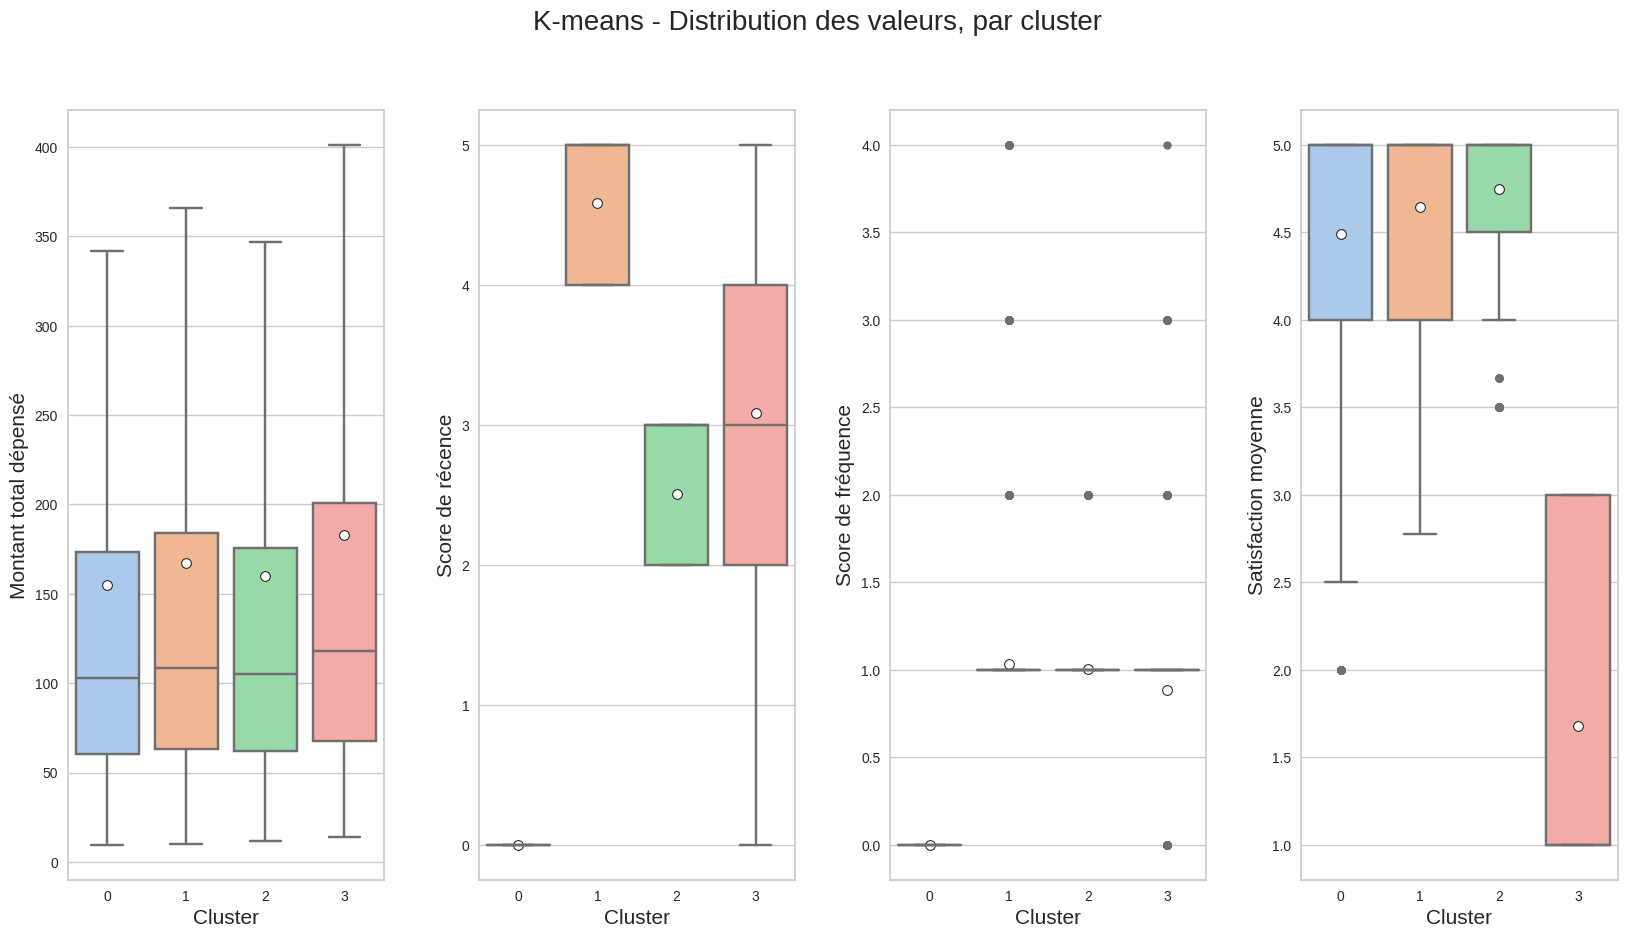

In [37]:
kmean_model = KMeans(n_clusters=4)
kmean_y = kmean_model.fit(X)

df_inputData['labels'] = kmean_model.labels_

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))

sns.boxplot(y="total_spent",
            x='labels',
            data=df_inputData,
            showfliers=False,
            ax=ax1,
            palette='pastel')
myn = df_inputData.groupby('labels').mean()['total_spent']
ax1.scatter(myn.index,
            myn,
            marker='o',
            facecolor='w',
            edgecolor='k',
            linewidths=0.7)
ax1.set_ylabel('Montant total dépensé', fontsize=15)
ax1.set_xlabel('Cluster', fontsize=15)

sns.boxplot(y="Recence",
            x='labels',
            data=df_inputData,
            showfliers=False,
            ax=ax2,
            palette='pastel')
myn = df_inputData.groupby('labels').mean()['Recence']
ax2.scatter(myn.index,
            myn,
            marker='o',
            facecolor='w',
            edgecolor='k',
            linewidths=0.7)

ax2.set_ylabel('Score de récence', fontsize=15)
ax2.set_xlabel('Cluster', fontsize=15)

sns.boxplot(y="Frequence",
            x='labels',
            data=df_inputData,
            showfliers=True,
            ax=ax3,
            palette='pastel',
            flierprops=flierprop)
myn = df_inputData.groupby('labels').mean()['Frequence']
ax3.scatter(myn.index,
            myn,
            marker='o',
            facecolor='w',
            edgecolor='k',
            linewidths=0.7)

ax3.set_ylabel('Score de fréquence', fontsize=15)
ax3.set_xlabel('Cluster', fontsize=15)

sns.boxplot(y="mean_review_score",
            x='labels',
            data=df_inputData,
            showfliers=True,
            ax=ax4,
            palette='pastel',
            flierprops=flierprop)
myn = df_inputData.groupby('labels').mean()["mean_review_score"]
ax4.scatter(myn.index,
            myn,
            marker='o',
            facecolor='w',
            edgecolor='k',
            linewidths=0.7)

ax4.set_ylabel('Satisfaction moyenne', fontsize=15)
ax4.set_xlabel('Cluster', fontsize=15)

plt.subplots_adjust(wspace=0.3)
fig.suptitle("K-means - Distribution des valeurs, par cluster", fontsize=20)
plt.savefig("P5_clustering/kmeans_alldata/boxplot_clusters.png",
            bbox_inches='tight')

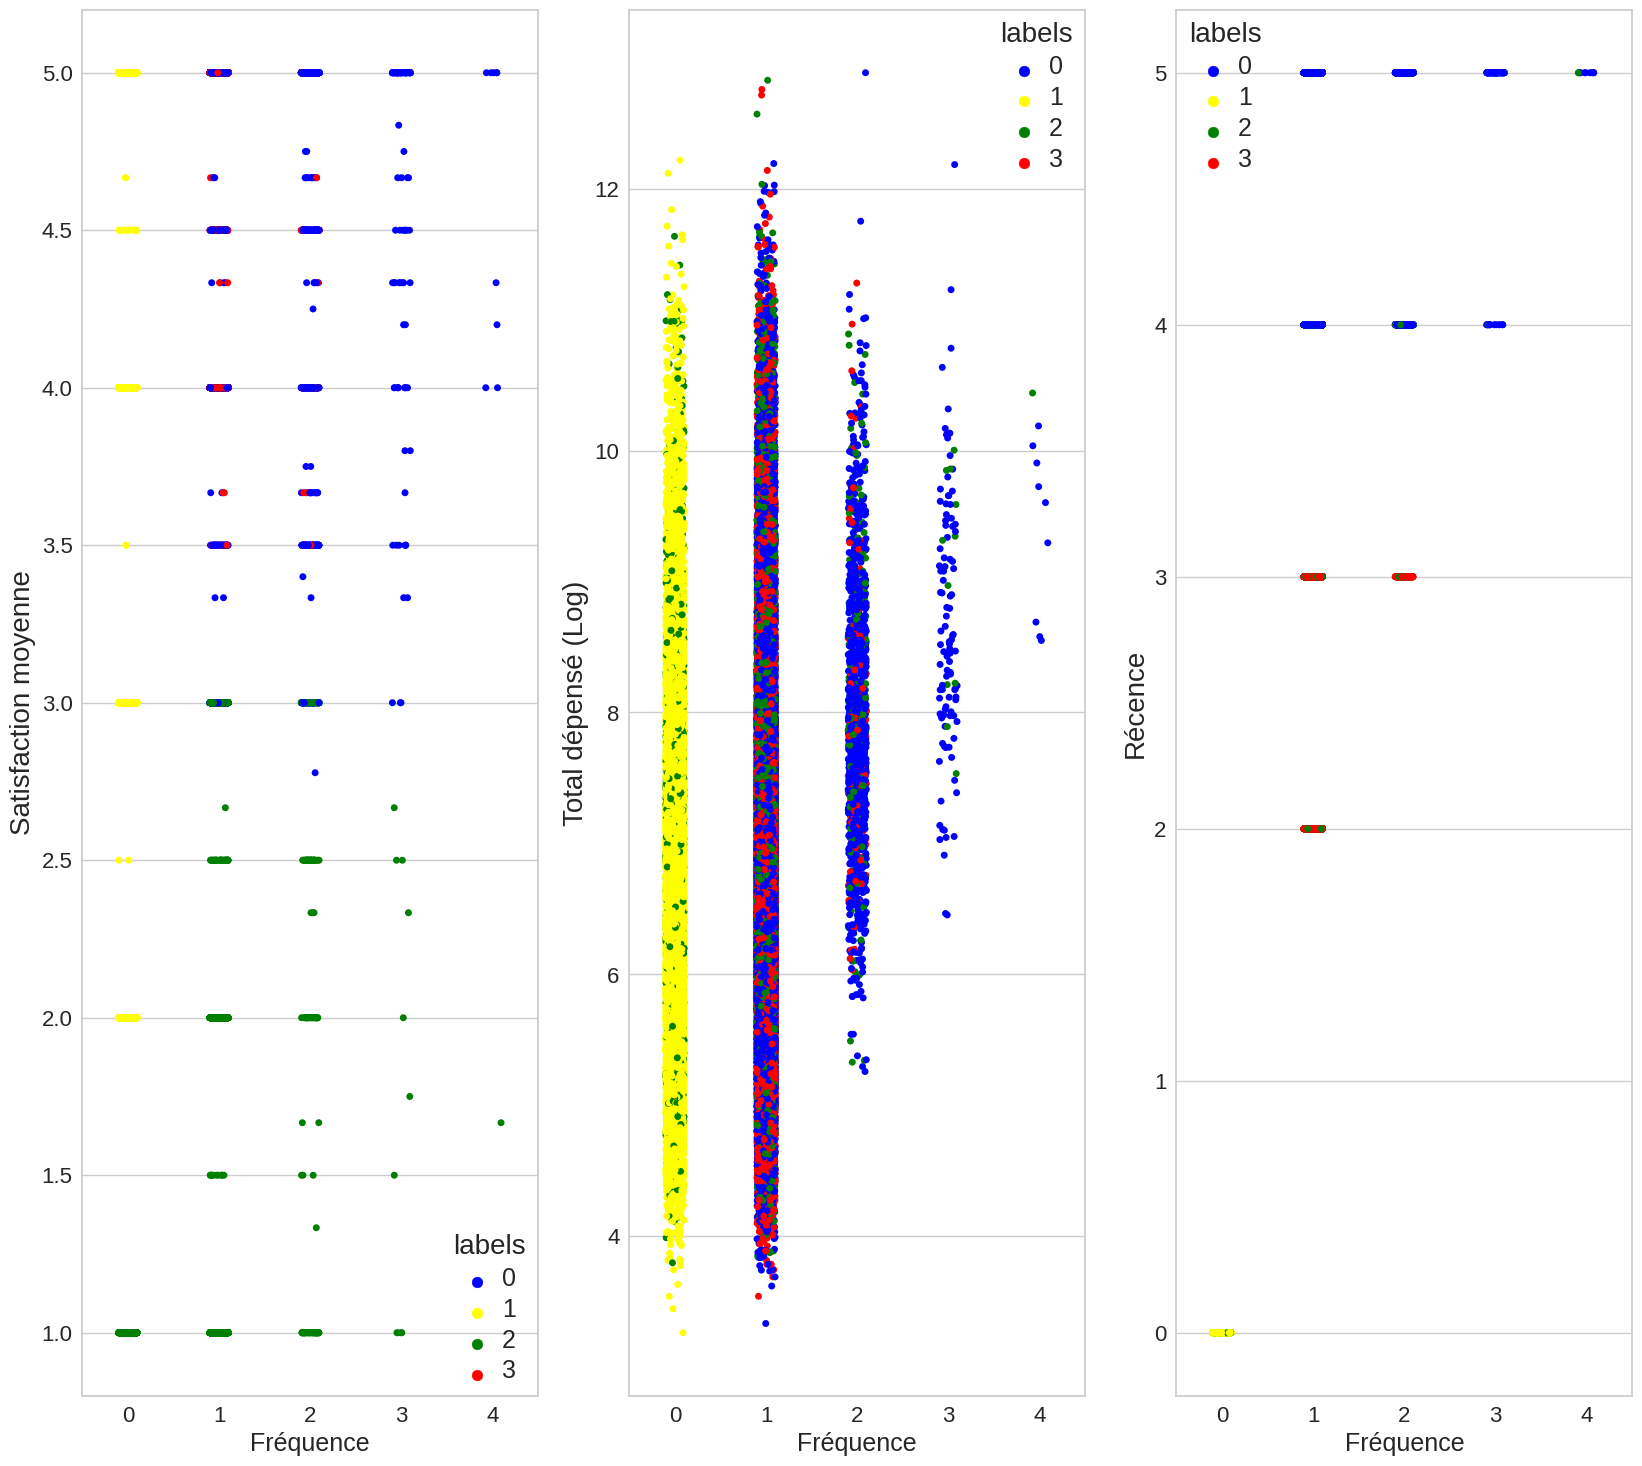

In [18]:
colonnes = {
    'mean_review_score': 'Satisfaction moyenne',
    'total_spent_log': 'Total dépensé (Log)',
    'Recence': 'Récence'
}
colors = ['blue', 'yellow', 'green', 'red']

fig, axes = plt.subplots(1, 3, figsize=(20, 18), sharex=False)

for i in range(0, len(colonnes)):
    col = list(colonnes)[i]

    ax = sns.stripplot(x=df_inputData['Frequence'],
                       y=df_inputData[col].values,
                       hue=df_inputData['labels'],
                       jitter=True,
                       ax=axes[(i)],
                       palette=colors)

    ax.set_ylabel(list(colonnes.values())[i], fontsize=20)
    ax.set_xlabel('Fréquence', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    plt.setp(ax.get_legend().get_title(), fontsize='20')

plt.savefig("P5_clustering/kmeans_alldata/stripplot_clusters.png",
            bbox_inches='tight')

## Visualisation des données - t-SNE

In [19]:
tsne = manifold.TSNE(n_components=2,
                     init="pca",
                     learning_rate="auto",
                     perplexity=50,
                     n_iter=1000)
trans_data = tsne.fit_transform(X)

/home/camille/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


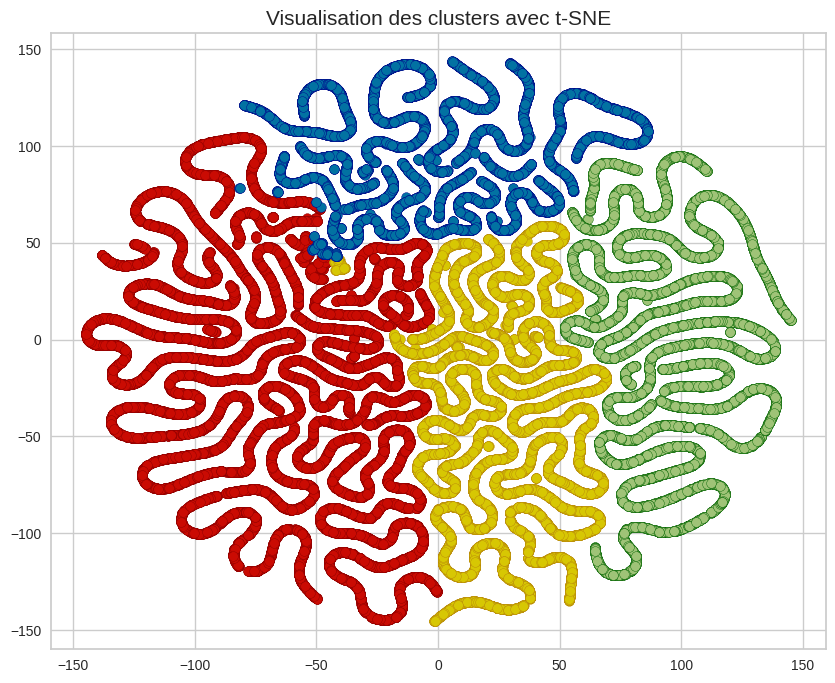

In [20]:
df_transdata = pd.DataFrame(trans_data, index=df_inputData.index)
df_transdata = df_transdata.merge(df_inputData['labels'],
                                  left_index=True,
                                  right_index=True)

colors = ['r', 'g', 'b', 'y']
edge = ['darkred', 'darkgreen', 'darkblue', 'darkgoldenrod']

fig, ax = plt.subplots(figsize=(10, 8))
for label in df_transdata.labels.unique():
    tmp = df_transdata[df_transdata.labels == label]
    plt.scatter(tmp[0], tmp[1], color=colors[label],edgecolor=edge[label])
plt.title("Visualisation des clusters avec t-SNE", fontsize=15)
plt.savefig("P5_clustering/kmeans_alldata/TSNE_clusters.png",
            bbox_inches='tight')

plt.show()

/home/camille/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


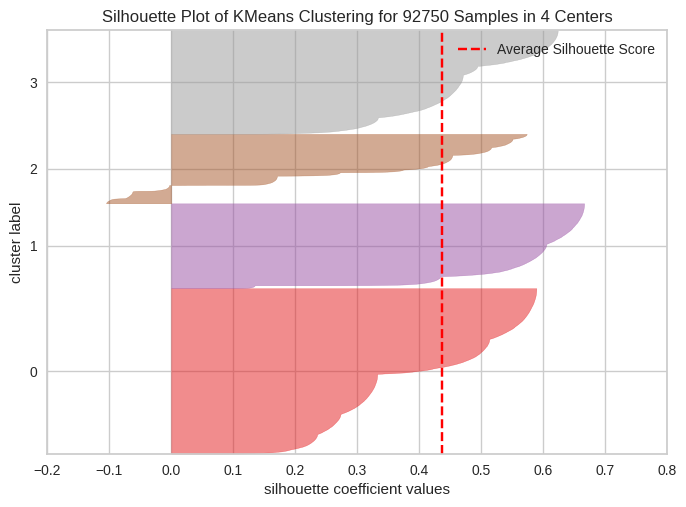

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 92750 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [21]:
# K-means silhouette score
visualizer = SilhouetteVisualizer(kmean_model)
visualizer.fit(X) 

visualizer.show()
